# Generate figures for IJCAI poster and presentation 

**Paper:** *Solving the Identifying Code Set Problem with Independent Support*

**By:** Anna L.D. Latour, Arunabha Sen, Kuldeep S. Meel
    
**Presented at:** IJCAI 2023, paper #4051

**Contact:** latour@nus.edu.sg


Copyright (C) 2022 Anna L.D. Latour

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.


### Research questions

We generate the figures for four main research questions:

**Q1**: How many instances are solved by `gismo` and `PBPBS`?

**Q2**: How do the solving times of `gismo` and `PBPBS` scale with $k$ and $|V|$?

**Q3**: How does the model size of the CNF encoding scale with $k$ and $|V|$?

**Q4**: How do the solution qualities of `gismo` and `PBPBS` compare?


### Prerequisites

Make sure that the following environment variables are defined:

- `LOCAL_PROJECT_DIR`: the directory with all the project code.
- `DATA_DIR`: the directory to store all the raw output files from the experiments, as well as the json files obtained after parsing.

Also, the following scripts need to be run in order to generate json files with experimental data, obtained from parsing the raw output files from the experiments:

```bash
user@machine:~$ cd $LOCAL_PROJECT_DIR/scripts/data-analysis
user@machine data-analysis$ python parse_files.py --expid IC22 --exptype encoding --enctype gis
user@machine data-analysis$ python parse_files.py --expid IC23 --exptype gis
user@machine data-analysis$ python parse_files.py --expid IC24 --exptype encoding --enctype ilp
user@machine data-analysis$ python parse_files.py --expid IC25 --exptype ilp
user@machine data-analysis$ python collect_network_stats.py
```

In [1]:
# Generally useful packages:
import gzip
import json
import os
import re
import sys

# Packages for manipulating data:
import copy
import numpy as np
import pandas as pd
from math import ceil, floor, log, sqrt
from scipy.optimize import least_squares
from statistics import median, mean

# Packages for making figures (that look good):
import matplotlib
matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tolatex

%matplotlib inline

# Helper script for processing json files with results:
LOCAL_PROJECT_DIR = os.getenv('PROJECT_DIR')
sys.path.insert(1, f'{LOCAL_PROJECT_DIR}/scripts/data-analysis')
from data_aggregator import DataAggregator

In [2]:
# Define helpful directories:
DATA_DIR = os.getenv('DATA_DIR')
JSON_DIR = f'{DATA_DIR}/exp-data'
NETWORK_DIR = f'{DATA_DIR}/instances/networks'
STATS_DIR = f'{DATA_DIR}/exp-data/network-stats'

In [3]:
save_png = True

## Setup

### Define the scope

We will generate figures and tables for both the GIS and the ILP pipeline.

**IC22**: Encoding the graphs into CNF/GIS.

**IC23**: Solving the GIS instances with gismo.

**IC24**: Encoding the graphs into ILP.

**IC25**: MIP-solving the ILPs with CPLEX.

In [4]:
# Experiment IDs
gis_enc_expid = 'IC22'
ilp_enc_expid = 'IC24'
gis_sol_expid = 'IC23'
ilp_sol_expid = 'IC25'

# Subdirectories in which the networks are stored
networktypes = [
    'kaustav', 'geometric',
    'infrastructure', 'power', 'road', 'webgraph',
    'collaboration', 'social'
]

# Values for maximum identifiable set size
k_values = ['1', '2', '3', '4', '6', '8', '10', '12', '16']

# ILP encoding configurations
ilp_configs = [
    'config0',   # No optimisations
    'config1'    # Remove supersets
]
gis_configs = ['config-0']   # No choice in configuration, because we didn't implement any

# JSON fields for the encoding step
enc_fields = {
    'output_header': ['benchmark', 'network_type', 'encoding', 'configuration'],
    'encoding_details': ['k'],
    'network_data': ['n_nodes', 'n_edges'],
    'cnf_data': ['n_vars', 'n_clauses', 'n_groups', 'n_Avars'],
    'timeout_info': ['utime', 'max_res_set_size', 'exit_status'],
    'ilp_data': ['n_vars', 'n_csts'],
  }

# JSON fields for the solving step
solve_fields = {
    'output_header': [
        'benchmark', 'network_type',
        'timeout', 'memory_limit'
    ],
    'timeout_info': [
        'utime', 'stime', 'wtime',
        'max_res_set_size',
        'exit_status', 'signal'
    ],
    'cplex_info': [
        'solution_time',
        'deterministic_time',
        'memout',
        'all_rows_eliminated_during_preprocessing',
        'n_rows', 'n_non_zeros', 'n_binaries'
    ],
    'solution_info': [
        'optimised_value',
        'k'
    ]
}

# Make JSON fields encoding-specific

ilp_enc_fields = copy.deepcopy(enc_fields)
ilp_enc_fields['output_header'].append('ilp_configuration')
ilp_enc_fields['encoding_details'].extend(['encoding_t/o', 'building_successful', 'encoding_successful'])

gis_enc_fields = copy.deepcopy(enc_fields)
gis_enc_fields['cnf_data'] = ['n_vars', 'n_clauses', 'n_groups', 'n_Avars']

ilp_sol_fields = copy.deepcopy(solve_fields)
ilp_enc_fields['ilp_data'] = ['n_vars', 'n_csts']
ilp_sol_fields['output_header'].append('ilp_configuration')

gis_sol_fields = copy.deepcopy(solve_fields)
gis_sol_fields['cnf_data'] = ['n_vars', 'n_clauses', 'n_groups', 'n_Avars']
gis_sol_fields['arjun_info'] = ['arjun_time']


### Define experimental parameters


In [5]:
enc_timeout = 3600
sol_timeout = 7200

tot_timeout = 3600     # We use this to evaluate the entire pipeline

enc_memout = 4000000   # 4 GB
sol_memout = 4000000   # 4 GB

penalty_factor = 2

### Specify the relevant networks

In [6]:
# The file with relevant networks contains the networks that we consider for the
# experiments. They are selected as real-world networks of varying sizes that
# do not contain any errors in their encoding.

relevant_networks = []
relevant_network_file = f'{LOCAL_PROJECT_DIR}/scripts/data-analysis/relevant_networks.txt'
with open(relevant_network_file, 'r') as infile:
    relevant_networks = [line.replace('.gz\n', '') for line in infile.readlines()]
print("Number of relevant networks:", len(relevant_networks))

relevant_networks_social = []
relevant_networks_social_file = f'{LOCAL_PROJECT_DIR}/scripts/data-analysis/relevant_networks_social.txt'
with open(relevant_networks_social_file, 'r') as infile:
    relevant_networks_social = [line.replace('.gz\n', '') for line in infile.readlines()]
print("Number of relevant social networks:", len(relevant_networks_social))

relevant_networks_grid = []
relevant_networks_grid_file = f'{LOCAL_PROJECT_DIR}/scripts/data-analysis/relevant_networks_grids.txt'
with open(relevant_networks_grid_file, 'r') as infile:
    relevant_networks_grid = [line.replace('.gz\n', '') for line in infile.readlines()]
print("Number of relevant grid networks:", len(relevant_networks_grid))

Number of relevant networks: 50
Number of relevant social networks: 32
Number of relevant grid networks: 18


## Get the data

### Load the data

We first identify and load all the relevant datasets. Here is a description of the experiment IDs:

In [7]:
ilp_enc_data = DataAggregator(
    ilp_enc_expid, 
    'encoding', 
    JSON_DIR,
    encodings=['ilp'],
    k_values=k_values,
    network_types=networktypes,
    configs=ilp_configs,
    relevant_fields=ilp_enc_fields
).get_data()

gis_enc_data = DataAggregator(
    gis_enc_expid, 
    'encoding', 
    JSON_DIR,
    encodings=['gis'],
    k_values=k_values,
    network_types=networktypes,
    configs=gis_configs,
    relevant_fields=gis_enc_fields
).get_data()

ilp_sol_data = DataAggregator(
    ilp_sol_expid, 
    'ilp', 
    JSON_DIR,
    encodings=['ilp'],
    k_values=k_values,
    network_types=networktypes,
    configs=ilp_configs,
    relevant_fields=ilp_sol_fields
).get_data()

gis_sol_data = DataAggregator(
    gis_sol_expid, 
    'gis', 
    JSON_DIR,
    encodings=['gis'],
    k_values=k_values,
    network_types=networktypes,
    configs=gis_configs,
    relevant_fields=gis_sol_fields
).get_data()

# Only keep data for the relevant networks
ilp_enc_data = ilp_enc_data[ilp_enc_data['benchmark'].isin(relevant_networks)].copy()
gis_enc_data = gis_enc_data[gis_enc_data['benchmark'].isin(relevant_networks)].copy()
ilp_sol_data = ilp_sol_data[ilp_sol_data['benchmark'].isin(relevant_networks)].copy()
gis_sol_data = gis_sol_data[gis_sol_data['benchmark'].isin(relevant_networks)].copy()

# Make sure columns are of the right datatype
ilp_enc_data.k = ilp_enc_data.k.astype(int)
ilp_sol_data.k = ilp_sol_data.k.astype(int)
gis_enc_data.dropna(subset=['k'], inplace=True)
gis_enc_data.k = gis_enc_data.k.astype(int)
gis_sol_data.k = gis_sol_data.k.astype(int)
gis_sol_data.optimised_value = gis_sol_data.optimised_value.astype(int)

ilp_data = pd.merge(ilp_enc_data,
                    ilp_sol_data, 
                    suffixes=['_enc', '_solve'], 
                    how='left', 
                    on=['ilp_configuration', 'benchmark', 'network_type', 'k'])
gis_data = pd.merge(gis_enc_data, 
                    gis_sol_data, 
                    suffixes=['_enc', '_solve'], 
                    how='left', 
                    on=['benchmark', 'network_type', 'k'])

SBG.txt.gcnf.gz.json.gz
PhilippineAdj.txt.gcnf.gz.json.gz
Test.txt.gcnf.gz.json.gz
ParisAdj.txt.gcnf.gz.json.gz
MadridAdj.txt.gcnf.gz.json.gz
ZerkaniAdj.txt.gcnf.gz.json.gz
soccer_ball.txt.gcnf.gz.json.gz
inf-USAir97.mtx.gcnf.gz.json.gz
power-494-bus.mtx.gcnf.gz.json.gz
power-eris1176.mtx.gcnf.gz.json.gz
power-bcspwr09.mtx.gcnf.gz.json.gz
power-685-bus.mtx.gcnf.gz.json.gz
power-1138-bus.mtx.gcnf.gz.json.gz
power-US-Grid.mtx.gcnf.gz.json.gz
road-euroroad.edges.gcnf.gz.json.gz
road-roadNet-PA.mtx.gcnf.gz.json.gz
road-luxembourg-osm.mtx.gcnf.gz.json.gz
road-chesapeake.mtx.gcnf.gz.json.gz
road-minnesota.mtx.gcnf.gz.json.gz
web-EPA.edges.gcnf.gz.json.gz
web-webbase-2001.mtx.gcnf.gz.json.gz
web-edu.mtx.gcnf.gz.json.gz
web-indochina-2004.mtx.gcnf.gz.json.gz
web-spam.mtx.gcnf.gz.json.gz
ca-CondMat.mtx.gcnf.gz.json.gz
ca-GrQc.mtx.gcnf.gz.json.gz
ca-citeseer.mtx.gcnf.gz.json.gz
ca-Erdos992.mtx.gcnf.gz.json.gz
ca-dblp-2010.mtx.gcnf.gz.json.gz
ca-sandi_auths.mtx.gcnf.gz.json.gz
ca-netscience.mtx.g

socfb-Oberlin44.mtx.gcnf.gz.json.gz
socfb-Wellesley22.mtx.gcnf.gz.json.gz
socfb-Caltech36.mtx.gcnf.gz.json.gz
socfb-Amherst41.mtx.gcnf.gz.json.gz
socfb-Reed98.mtx.gcnf.gz.json.gz
socfb-Colgate88.mtx.gcnf.gz.json.gz
socfb-Mich67.mtx.gcnf.gz.json.gz
socfb-Smith60.mtx.gcnf.gz.json.gz
SBG.txt.gcnf.gz.json.gz
PhilippineAdj.txt.gcnf.gz.json.gz
Test.txt.gcnf.gz.json.gz
ParisAdj.txt.gcnf.gz.json.gz
MadridAdj.txt.gcnf.gz.json.gz
ZerkaniAdj.txt.gcnf.gz.json.gz
soccer_ball.txt.gcnf.gz.json.gz
inf-USAir97.mtx.gcnf.gz.json.gz
power-494-bus.mtx.gcnf.gz.json.gz
power-eris1176.mtx.gcnf.gz.json.gz
power-bcspwr09.mtx.gcnf.gz.json.gz
power-685-bus.mtx.gcnf.gz.json.gz
power-1138-bus.mtx.gcnf.gz.json.gz
power-US-Grid.mtx.gcnf.gz.json.gz
road-euroroad.edges.gcnf.gz.json.gz
road-roadNet-PA.mtx.gcnf.gz.json.gz
road-luxembourg-osm.mtx.gcnf.gz.json.gz
road-chesapeake.mtx.gcnf.gz.json.gz
road-minnesota.mtx.gcnf.gz.json.gz
web-EPA.edges.gcnf.gz.json.gz
web-webbase-2001.mtx.gcnf.gz.json.gz
web-edu.mtx.gcnf.gz.json

### Preprocessing

In [8]:
# TODO: clean this up. The "np.where()" method is unreliable.

# Identify instances that could not be encoded due to timeout or memout

ilp_data['encoding_t/o'] = np.where(
    (ilp_data.utime_enc > 0.95*enc_timeout) &
    (ilp_data.max_res_set_size_enc <= enc_memout - 500000), 
    True, False)
ilp_data['encoding_m/o'] = np.where(
    (ilp_data.utime_enc <= 0.95*enc_timeout) &
    (ilp_data.max_res_set_size_enc > enc_memout - 500000),
    True, False)

gis_data['encoding_t/o'] = np.where(
    gis_data.exit_status_enc == 124,
    True, False)
gis_data['encoding_m/o'] = np.where(
    (~gis_data['encoding_t/o']) &
    (gis_data.max_res_set_size_enc > enc_memout - 500000),
    True, False)

# Identify instances that could not be solved due to timeout, memout or other errors

ilp_data['solving_t/o'] = np.where(
    (ilp_data.utime_solve > 0.95*sol_timeout) &
    (ilp_data.max_res_set_size_solve <= sol_memout - 500000), 
    True, False)
ilp_data['solving_m/o'] = np.where(
    (ilp_data.utime_solve <= 0.95*sol_timeout) &
    (ilp_data.max_res_set_size_solve > sol_memout - 500000),
    True, False)

gis_data['solving_m/o'] = np.where(
    (gis_data.exit_status_solve == 1),
    True, False)
gis_data['solving_t/o'] = np.where(
    (gis_data.exit_status_solve == 124),
    True, False)
gis_data['other_error'] = np.where(
    (gis_data.exit_status_solve.isin([134, 139])),
     True, False)


# TODO PHASE OUT THE FOLLOWING
# Introduce helper columns that indicate timeouts and memouts
# NOTE: there seems to be a problem with the logging of the (un)succesfull encoding reporting, 
# so the following is unreliable.
ilp_enc_data.loc[
    ilp_enc_data.building_successful &
#     ~ilp_enc_data.encoding_successful &
    (ilp_enc_data.utime > 0.95*enc_timeout) &
    (ilp_enc_data.max_res_set_size <= enc_memout - 500000), 'encoding_t/o'
] = True
ilp_enc_data.loc[
    ilp_enc_data.building_successful &
    ~ilp_enc_data.encoding_successful &
    (ilp_enc_data.utime < enc_timeout) &
    (ilp_enc_data.max_res_set_size > enc_memout - 500000), 'encoding_m/o'
] = True




## Plotting

### Aesthetics (for figures)

In [9]:
column = 2

col_width_in = 3.35  # According to IJCAI 2022 guidelines
col_gap_in = 0.25     # According to IJCAI 2022 guidelines
textwidth_in = 2*col_width_in + col_gap_in 

col_width_pt = col_width_in*72

def get_fig_height(f_width):
    golden_mean = (sqrt(5) - 1.0) / 2.0  # Aesthetic ratio
    return f_width * golden_mean / 1.5

c_ilp = '#EE7BCA'  # hot pink
c_timeout = '#C03251'  # red wine stain
c_gis = '#D47E56'  # orange

summerwander2 = '#8B2B90'  # purple
summerwander4 = '#276ABE'  # strong blue
summerwander5 = '#6CACE3'  # light strong blue
nusblue = '#003D7C'

style = {
    'fail': {
        'c': c_timeout,
        'ls': '-',
    },
    'ilp-csts': {
        'c': c_ilp,
        'ls': '-',
        'm': 'o'
    },
    'ilp-vars': {
        'c': c_ilp,
        'ls': '--',
        'm': 's'
    },
    'gis-clss': {
        'c': c_gis,
        'ls': '-',
        'm': '+'
    },
    'gis-vars': {
        'c': c_ilp,
        'ls': '--',
        'm': 'x'
    },
}

### Plotting helper functions

In [10]:

def isPower (x, y):
    # From https://www.geeksforgeeks.org/check-if-a-number-is-power-of-another-number/

    # The only power of 1
    # is 1 itself
    if (x == 1):
        return (y == 1)

    # Repeatedly compute
    # power of x
    pow = 1
    while (pow < y):
        pow = pow * x

    # Check if power of x
    # becomes y
    return (pow == y)
        
def get_lower_bound(number):
    zeros = 0
    while number > 10:
        number = number/10
        zeros = zeros + 1
    return floor(number), zeros

def get_upper_bound(number):
    zeros = 0
    while number > 10:
        number = number/10
        zeros = zeros + 1
    return ceil(number), zeros

def compute_ticks_bounds(the_values):
    ub_num, ub_zeros = get_upper_bound(max(the_values))
    lb_num, lb_zeros = get_lower_bound(min(the_values))
    ub = ub_num * 10**ub_zeros
    lb = lb_num * 10**lb_zeros
    ticks = []
    if lb_zeros == ub_zeros:
        ticks = range(lb, ub + 1, 10**ub_zeros)
    elif lb_zeros == ub_zeros - 1:
        lb = 0
        ticks = range(lb, ub + 1, 10**ub_zeros)
    if len(ticks) < 3:
        ticks = range(lb, ub + 1, int(0.5 * 10 ** ub_zeros))
    return ticks

def latexify_integer(myint, group=3, char='\\,'):
    if myint < 1000:
        return str(myint)
    else:
        # From https://stackoverflow.com/a/30919497
        myint_str = str(myint)
        return ((char[::-1]).join((myint_str[::-1])[i:i+group] for i in range(0, len(myint_str), group)))[::-1]

## More plots

Here are some more plots that we can use to analyse our data, but which didn't make it to the paper or the technical appendix.

### Solving Time Comparison

fig_width: 3.7520000000000007
fig_height: 3.7520000000000007
ParisAdj.txt
PhilippineAdj.txt
ca-sandi_auths.mtx
soccer_ball.txt
ZerkaniAdj.txt
road-chesapeake.mtx
MadridAdj.txt
soc-dolphins.mtx
inf-USAir97.mtx
ca-netscience.mtx
power-494-bus.mtx
power-685-bus.mtx
socfb-Caltech36.mtx
socfb-Reed98.mtx
power-1138-bus.mtx
road-euroroad.edges
power-eris1176.mtx
socfb-Haverford76.mtx
socfb-Simmons81.mtx
socfb-Swarthmore42.mtx
power-bcspwr09.mtx
socfb-Amherst41.mtx
socfb-Bowdoin47.mtx
socfb-Hamilton46.mtx
socfb-Trinity100.mtx
road-minnesota.mtx
socfb-USFCA72.mtx
socfb-Williams40.mtx
socfb-nips-ego.edges
socfb-Oberlin44.mtx
socfb-Smith60.mtx
socfb-Wellesley22.mtx
web-edu.mtx
socfb-Vassar85.mtx
socfb-Middlebury45.mtx
socfb-Pepperdine86.mtx
socfb-Colgate88.mtx
socfb-Mich67.mtx
ca-GrQc.mtx
web-EPA.edges
web-spam.mtx
power-US-Grid.mtx
ca-Erdos992.mtx
web-indochina-2004.mtx
web-webbase-2001.mtx
ca-CondMat.mtx
road-luxembourg-osm.mtx
ca-dblp-2010.mtx
ca-citeseer.mtx
road-roadNet-PA.mtx


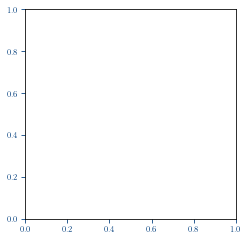

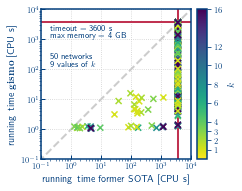

fig_width: 3.7520000000000007
fig_height: 3.7520000000000007
ParisAdj.txt
PhilippineAdj.txt
ca-sandi_auths.mtx
soccer_ball.txt
ZerkaniAdj.txt
road-chesapeake.mtx
MadridAdj.txt
soc-dolphins.mtx
inf-USAir97.mtx
ca-netscience.mtx
power-494-bus.mtx
power-685-bus.mtx
socfb-Caltech36.mtx
socfb-Reed98.mtx
power-1138-bus.mtx
road-euroroad.edges
power-eris1176.mtx
socfb-Haverford76.mtx
socfb-Simmons81.mtx
socfb-Swarthmore42.mtx
power-bcspwr09.mtx
socfb-Amherst41.mtx
socfb-Bowdoin47.mtx
socfb-Hamilton46.mtx
socfb-Trinity100.mtx
road-minnesota.mtx
socfb-USFCA72.mtx
socfb-Williams40.mtx
socfb-nips-ego.edges
socfb-Oberlin44.mtx
socfb-Smith60.mtx
socfb-Wellesley22.mtx
web-edu.mtx
socfb-Vassar85.mtx
socfb-Middlebury45.mtx
socfb-Pepperdine86.mtx
socfb-Colgate88.mtx
socfb-Mich67.mtx
ca-GrQc.mtx
web-EPA.edges
web-spam.mtx
power-US-Grid.mtx
ca-Erdos992.mtx
web-indochina-2004.mtx
web-webbase-2001.mtx
ca-CondMat.mtx
road-luxembourg-osm.mtx
ca-dblp-2010.mtx
ca-citeseer.mtx
road-roadNet-PA.mtx
No data for ro

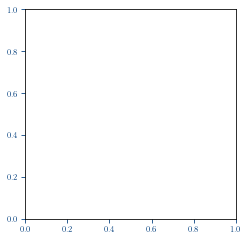

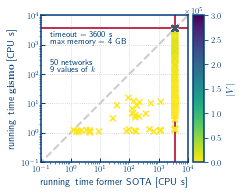

fig_width: 3.7520000000000007
fig_height: 3.7520000000000007
ParisAdj.txt
PhilippineAdj.txt
ca-sandi_auths.mtx
soccer_ball.txt
ZerkaniAdj.txt
road-chesapeake.mtx
MadridAdj.txt
soc-dolphins.mtx
inf-USAir97.mtx
ca-netscience.mtx
power-494-bus.mtx
power-685-bus.mtx
socfb-Caltech36.mtx
socfb-Reed98.mtx
power-1138-bus.mtx
road-euroroad.edges
power-eris1176.mtx
socfb-Haverford76.mtx
socfb-Simmons81.mtx
socfb-Swarthmore42.mtx
power-bcspwr09.mtx
socfb-Amherst41.mtx
socfb-Bowdoin47.mtx
socfb-Hamilton46.mtx
socfb-Trinity100.mtx
road-minnesota.mtx
socfb-USFCA72.mtx
socfb-Williams40.mtx
socfb-nips-ego.edges
socfb-Oberlin44.mtx
socfb-Smith60.mtx
socfb-Wellesley22.mtx
web-edu.mtx
socfb-Vassar85.mtx
socfb-Middlebury45.mtx
socfb-Pepperdine86.mtx
socfb-Colgate88.mtx
socfb-Mich67.mtx
ca-GrQc.mtx
web-EPA.edges
web-spam.mtx
power-US-Grid.mtx
ca-Erdos992.mtx
web-indochina-2004.mtx
web-webbase-2001.mtx
ca-CondMat.mtx
road-luxembourg-osm.mtx
ca-dblp-2010.mtx
ca-citeseer.mtx
road-roadNet-PA.mtx
No data for ro

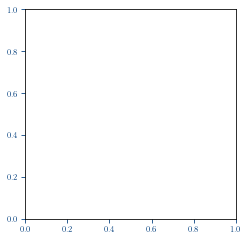

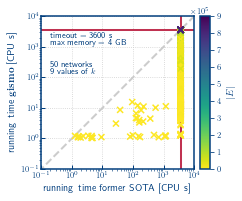

NameError: name 'plot_enc_size_square' is not defined

<Figure size 271.843x271.843 with 0 Axes>

In [32]:
def plot_solving_time_square(instances=None, size_param='k', ilp_config='config1'):
    """Plot solving times for ILP and GIS method, with k, n_nodes, n_edges, or median degree visualised in colour.

    Args:
        instances (list): A list of instances that we want to include in the plot.
        size_param (str): Choose from: {k, n_nodes, n_edges, median_degree}
        ilp_config (str): Choose from: {config0, config1}

    """

    # Set up the figure
    
    correction = 1.12     # May need this to make the figures actually the right size
    fig_width = col_width_in * correction
    tolatex.latexify(fig_width=fig_width, fig_height=fig_width, columns=column)
    plt.minorticks_off()
    fig, ax = plt.subplots(1, 1)
    cm = plt.cm.get_cmap('viridis_r')

    # Extract extreme values    
    max_colour = max(
        ilp_enc_data[ilp_enc_data['benchmark'].isin(instances)][size_param].max(), 
        gis_enc_data[gis_enc_data['benchmark'].isin(instances)][size_param].max())
    
    if size_param in ['n_nodes', 'n_edges']:
        number, zeros = get_upper_bound(max_colour)
        colour_ub = number * 10**(zeros)
    elif size_param == 'k':
        colour_ub = 16

    for instance in instances:
        print(instance)
        ilp_data_inst = ilp_data[
            (ilp_data['benchmark'] == instance) &
            (ilp_data['ilp_configuration'] == ilp_config)].copy()
        gis_data_inst = gis_data[
            (gis_data['benchmark'] == instance)].copy()        
        
        # Update values of failure:
#         ilp_data_inst.utime_solve = np.where(
#             (ilp_data_inst.n_vars.isna()) | (ilp_data_inst.optimised_value.isna()),
#             sol_timeout, ilp_data_inst.utime_solve)
#         gis_data_inst.utime_solve = np.where(
#             (gis_data_inst.n_vars.isna()) | (gis_data_inst.optimised_value < 0),
#             sol_timeout, gis_data_inst.utime_solve)
        
        ilp_data_inst['utime_tot'] = np.where(
            (~ilp_data_inst.n_vars.isna()) &          # Instance was encoded
            (~ilp_data_inst.optimised_value.isna()) & # Instance was solved
            (ilp_data_inst.utime_enc + ilp_data_inst.utime_solve <= tot_timeout),
            ilp_data_inst.utime_enc + ilp_data_inst.utime_solve, tot_timeout)
        gis_data_inst['utime_tot'] = np.where(
            (~gis_data_inst.n_vars.isna()) &          # Instnace was encoded
            (gis_data_inst.optimised_value > -1) &    # Instance was solved
            (gis_data_inst.utime_enc + gis_data_inst.utime_solve <= tot_timeout),  # Total time did not exceed tot_timeout
            gis_data_inst.utime_enc + gis_data_inst.utime_solve, tot_timeout)
        
#         print(ilp_data.utime_tot)

        # Sort values by k
        ilp_data_inst.sort_values('k', inplace=True)
        gis_data_inst.sort_values('k', inplace=True)


        # Extract k values, number of clauses, number of variables
        X_ilp = ilp_data_inst['utime_tot'].tolist() 
        Y_gis = gis_data_inst['utime_tot'].tolist()
        Z = gis_data_inst[size_param].tolist()
        
        if np.isnan(Z[0]):
            print(f"No data for {instance}.")
            continue

        # Plot
        sc = ax.scatter(X_ilp, Y_gis, c=Z, marker='x', vmin=0, vmax=colour_ub, cmap=cm, zorder=3)

    diag_X = range(0, int(sol_timeout * 1.3), 100)
    diag_Y = diag_X
    ax.plot(diag_X, diag_Y, '--', color='0.8', lw=2, zorder=1)

    timeout_var = range(0, int(tot_timeout * 10), 100)
    timeout_const = [tot_timeout] * len(timeout_var)
    ax.plot(timeout_var, timeout_const, '-', color=style['fail']['c'], lw=2, zorder=2)
    ax.plot(timeout_const, timeout_var, '-', color=style['fail']['c'], lw=2, zorder=2)

    

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel(r'{\sf running time former SOTA [CPU s]}', fontsize=10)
    ax.set_ylabel(r'{\sf running time {\bf gismo} [CPU s]}', fontsize=10)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.xaxis.grid(color='0.8', linestyle=':')
    ax.yaxis.grid(color='0.8', linestyle=':')
    plt.xlim([8, sol_timeout * 1.05])
    plt.ylim([8, sol_timeout * 1.05])
    ax.set_xticks([x for x in [0.1, 1, 10, 100, 1000, 10000, 100000, 1000000] if x < sol_timeout*10.3])
    ax.set_yticks([x for x in [0.1, 1, 10, 100, 1000, 10000, 100000, 1000000] if x < sol_timeout*10.3])
#     ax.text(0.2, 1250, r'{\sf timeout = 3600 s}', fontsize=8)
#     ax.text(0.2, 800, r'{\sf max memory = 4 GB}', fontsize=8)
#     ax.text(0.2, 450, r'{\sf 50 networks}', fontsize=8)
#     ax.text(0.2, 250, r'{\sf 9 values of} $k$', fontsize=8)
    ax.text(0.2, 2000, r'{\sf timeout = 3600 s}', fontsize=8)
    ax.text(0.2, 1100, r'{\sf max memory = 4 GB}', fontsize=8)
    ax.text(0.2, 225, r'{\sf 50 networks}', fontsize=8)
    ax.text(0.2, 125, r'{\sf 9 values of} $k$', fontsize=8)
    tolatex.format_axes(ax)
#     tolatex.format_axes(cax)
    
    matplotlib.rcParams['text.color'] = nusblue
    matplotlib.rcParams['axes.labelcolor'] = nusblue
    matplotlib.rcParams['xtick.color'] = nusblue
    matplotlib.rcParams['ytick.color'] = nusblue
    
    ax.spines['bottom'].set_color(nusblue)
    ax.spines['left'].set_color(nusblue)
    ax.spines['top'].set_color(nusblue)
    ax.spines['right'].set_color(nusblue)
    
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    
    ax.tick_params(axis='x', colors=nusblue, width=1)
    ax.tick_params(axis='y', colors=nusblue, width=1)
    
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.075)
    
    cbar = fig.colorbar(sc, cax=cax)
    cbar_label = ''
    if size_param == 'k':
        cbar_label = '$k$'
    elif size_param == 'n_nodes':
        cbar_label = '$|V|$'
    elif size_param == 'n_edges':
        cbar_label = '$|E|$'
     
    if size_param in ['n_nodes', 'n_edges']:
        cbar.formatter.set_powerlimits((0, 0))
        cbar.ax.yaxis.set_offset_position('right')                         
        cbar.update_ticks()
    elif size_param == 'k':
        cbar.set_ticks(sorted(gis_enc_data.k.unique()))
        
    cbar.outline.set_color(nusblue)
    cbar.outline.set_linewidth(1.5)

    cax.tick_params(axis='y', colors=nusblue)
    
    cbar.set_label(cbar_label, fontsize=10)
    fig.tight_layout()
    figname = f"{ilp_enc_expid}_{gis_enc_expid}_total-time-vs-{size_param}_ilp-{ilp_config}_square_ijcai_poster"
    plt.savefig(f"{figname}.pdf", bbox_inches="tight")
    if save_png:
        plt.savefig(f"{figname}.png", bbox_inches="tight", dpi=600)
    plt.show()
    plt.clf()

# instances = ilp_enc_data.benchmark.unique()
instances = relevant_networks
plot_solving_time_square(instances=instances, size_param='k', ilp_config='config1')
plot_solving_time_square(instances=instances, size_param='n_nodes', ilp_config='config1')
plot_solving_time_square(instances=instances, size_param='n_edges', ilp_config='config1')
plot_enc_size_square(instances=instances, size_param='k', ilp_config='config0')
plot_enc_size_square(instances=instances, size_param='n_nodes', ilp_config='config0')
plot_enc_size_square(instances=instances, size_param='n_edges', ilp_config='config0')